# **Alphabet Inc. Pipeline**
This initial use cases looks at the pipeline for GOOG earnings from 2019.

# Imports

In [36]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [2]:
!pip install dowhy causalinference

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

import networkx as nx
import dowhy
import causalinference
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests
from pgmpy.estimators import PC, HillClimbSearch
from pgmpy.estimators.CITests import chi_square, pearsonr as pgmpy_pearsonr

# Earnings



Historical earnings dataset queried from [Dolthub](https://www.dolthub.com/repositories/post-no-preference/earnings)

In [5]:
df_earning_hist = pd.read_csv("goog_earning_hist.csv")
df_earning_hist['earning_date'] = pd.to_datetime(df_earning_hist['earning_date']).dt.date
df_earning_hist['period_ending'] = pd.to_datetime(df_earning_hist['period_ending'])
# df_earning_hist['period_ending'] = df_earning_hist['period_ending'].apply(lambda d: d.replace(day=pd.Timestamp(d).days_in_month)).dt.date
# df_earning_hist['estimate'] = df_earning_hist['estimate'].replace({'\$': '', ',': ''}, regex=True).astype(float)
# df_earning_hist['reported'] = df_earning_hist['reported'].replace({'\$': '', ',': ''}, regex=True).astype(float)
# df_earning_hist['surprise'] = df_earning_hist['surprise'].astype(float)
# df_earning_hist['surprise_pct'] = df_earning_hist['surprise_pct'].replace({'%': '', ',': ''}, regex=True).astype(float)

In [6]:
df_earning_hist

,earning_date,period_ending,estimate,reported,surprise,surprise_pct,time
0,2025-02-04,2024-12-31,2.12,2.15,0.03,1.42,After Close
1,2024-10-29,2024-09-30,1.83,2.12,0.29,15.85,After Close
2,2024-07-23,2024-06-30,1.85,1.89,0.04,2.16,After Close
3,2024-04-25,2024-03-31,1.49,1.89,0.40,26.85,After Close
4,2024-01-30,2023-12-31,1.60,1.64,0.04,2.50,After Close
5,2023-10-24,2023-09-30,1.45,1.55,0.10,6.90,After Close
6,2023-07-25,2023-06-30,1.32,1.44,0.12,9.09,After Close
7,2023-04-25,2023-03-31,1.06,1.17,0.11,10.38,After Close
8,2023-02-02,2022-12-31,1.14,1.05,-0.09,-7.89,After Close
9,2022-10-25,2022-09-30,1.25,1.06,-0.19,-15.20,After Close


# Stock Prices

Historical stock data around earning dates extracted from yfinance with custom derived features

In [7]:
symbol = "GOOG"
stock_data = yf.Ticker(symbol)
historical_prices = stock_data.history(period="6y")
for days in range(1, 5):
    historical_prices[f'Close_prev_{days}D'] = historical_prices['Close'].shift(days)
historical_prices['Close_next_1D'] = historical_prices['Close'].shift(-1)

rolling_windows = [5, 7, 30]
for window in rolling_windows:
    historical_prices[f'Rolling_{window}D_Avg'] = historical_prices['Close'].rolling(window).mean()
    historical_prices[f'Rolling_{window}D_Std'] = historical_prices['Close'].rolling(window).std()

historical_prices['Daily_Price_Change'] = historical_prices['Close'].diff()
historical_prices['MACD'] = historical_prices['Close'].ewm(span=12, adjust=False).mean() - historical_prices['Close'].ewm(span=26, adjust=False).mean()
historical_prices['Bollinger_Upper'] = historical_prices['Close'].rolling(window=20).mean() + (2 * historical_prices['Close'].rolling(window=20).std())
historical_prices['Bollinger_Lower'] = historical_prices['Close'].rolling(window=20).mean() - (2 * historical_prices['Close'].rolling(window=20).std())

historical_prices.index = historical_prices.index.date

earnings_dates = df_earning_hist.earning_date
df_earning_hist['earning_date'] = pd.to_datetime(df_earning_hist['earning_date']).dt.date

df_price = historical_prices.loc[historical_prices.index.isin(earnings_dates)]
df_price['date'] = df_price.index

<ipython-input-7-9af602309360>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['date'] = df_price.index


In [8]:
df_price

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_prev_1D,Close_prev_2D,Close_prev_3D,...,Rolling_5D_Std,Rolling_7D_Avg,Rolling_7D_Std,Rolling_30D_Avg,Rolling_30D_Std,Daily_Price_Change,MACD,Bollinger_Upper,Bollinger_Lower,date
2019-04-29,63.399704,64.159605,63.016270,64.075500,49988000,0.0,0.0,63.309143,62.874699,NaN,...,NaN,NaN,NaN,NaN,NaN,0.766357,0.122548,NaN,NaN,2019-04-29
2019-07-25,56.622810,56.815895,55.781796,56.339153,44196000,0.0,0.0,56.622314,57.040333,56.635250,...,0.312719,56.709897,0.343750,55.667152,1.209893,-0.283161,0.378814,58.372696,53.950142,2019-07-25
2019-10-28,63.471859,64.659236,63.327045,64.195930,52264000,0.0,0.0,62.958302,62.752281,62.659714,...,0.846989,62.629713,0.815452,61.182445,1.253975,1.237629,0.803613,64.160533,58.102124,2019-10-28
2020-02-03,72.755399,74.148800,72.605611,73.946754,60736000,0.0,0.0,71.373444,72.448853,72.587700,...,0.923910,72.427026,0.906230,70.398478,2.587809,2.573311,1.263241,74.955859,69.000500,2020-02-03
2020-04-28,64.092927,64.098896,61.319564,61.392715,59026000,0.0,0.0,63.493263,63.663956,63.514668,...,0.942095,62.641373,1.207708,58.898829,3.630143,-2.100548,0.730345,66.625581,54.747641,2020-04-28
2020-07-30,74.497149,76.531019,74.259277,76.211533,33428000,0.0,0.0,75.742249,74.663361,76.149323,...,0.652862,75.926447,1.081276,74.051557,2.580130,0.469284,1.052906,78.162603,73.009426,2020-07-30
2020-10-29,75.759174,79.309862,75.753206,77.992599,40062000,0.0,0.0,75.473518,79.834869,79.147621,...,2.296991,79.112505,1.965463,75.405729,3.183461,2.519081,0.927368,82.399367,71.467452,2020-10-29
2021-02-02,95.674842,97.327021,95.273249,95.921181,45474000,0.0,0.0,94.619339,91.354309,92.716354,...,2.086904,93.664507,1.939033,89.375793,3.453187,1.301842,1.833094,97.703820,83.736349,2021-02-02
2021-04-27,116.249388,116.321541,114.670365,114.812195,31972000,0.0,0.0,115.788567,115.219269,112.861443,...,1.127258,114.503373,0.934198,108.695882,5.630768,-0.976372,2.844399,119.558906,104.335327,2021-04-27
2021-07-27,139.350966,139.350966,134.463121,136.151611,42164000,0.0,0.0,138.986191,137.166306,132.699982,...,2.981748,133.729664,3.782414,128.955772,3.724769,-2.834579,3.004014,137.849949,123.145505,2021-07-27


# Macro Data

Macro Data considered incldue general market volatility, Tech sector performance, feds interest rates.

In [9]:
vix = yf.Ticker("^VIX")
vix_data = vix.history(period="6y")

for days in range(1, 5):
    vix_data[f'Close_prev_{days}D'] = vix_data['Close'].shift(days)

rolling_windows = [5, 7, 30]
vix_data['VIX_Change'] = vix_data['Close'].pct_change()
for window in rolling_windows:
    vix_data[f'Rolling_{window}D_Avg'] = vix_data['Close'].rolling(window).mean()
    vix_data[f'Rolling_{window}D_Std'] = vix_data['Close'].rolling(window).std()

vix_data.index = vix_data.index.date
df_vix = vix_data.loc[vix_data.index.isin(earnings_dates)]

In [10]:
df_vix

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_prev_1D,Close_prev_2D,Close_prev_3D,Close_prev_4D,VIX_Change,Rolling_5D_Avg,Rolling_5D_Std,Rolling_7D_Avg,Rolling_7D_Std,Rolling_30D_Avg,Rolling_30D_Std
2019-04-29,13.040000,13.270000,12.650000,13.110000,0,0.0,0.0,12.730000,13.250000,13.140000,NaN,0.029851,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-25,12.240000,13.540000,11.690000,12.740000,0,0.0,0.0,12.070000,12.610000,13.530000,14.450000,0.055510,13.080000,0.926823,13.271428,0.834075,14.080333,1.259635
2019-10-28,13.010000,13.140000,12.660000,13.110000,0,0.0,0.0,12.650000,13.710000,14.010000,14.460000,0.036364,13.588000,0.717928,13.741429,0.646128,15.739667,2.188047
2020-02-03,18.639999,18.879999,17.100000,17.969999,0,0.0,0.0,18.840000,15.490000,16.389999,16.280001,-0.046178,16.994000,1.369025,16.822857,1.567585,13.856667,1.909653
2020-04-28,33.209999,35.389999,30.540001,33.570000,0,0.0,0.0,33.290001,35.930000,41.380001,41.980000,0.008411,37.230000,4.195063,39.341429,4.994325,50.664000,12.719992
2020-07-30,25.040001,28.290001,24.639999,24.760000,0,0.0,0.0,24.100000,25.440001,24.740000,25.840000,0.027386,24.976000,0.676668,25.040000,0.758507,28.674333,3.330458
2020-10-29,38.799999,41.160000,35.630001,37.590000,0,0.0,0.0,40.279999,33.349998,32.459999,27.549999,-0.066782,34.245999,4.909698,32.569999,4.928208,28.413333,3.425069
2021-02-02,28.010000,28.080000,25.309999,25.559999,0,0.0,0.0,30.240000,33.090000,30.209999,37.209999,-0.154762,31.262000,4.283231,28.931428,5.298601,24.506333,3.698923
2021-04-27,17.620001,18.160000,16.969999,17.559999,0,0.0,0.0,17.639999,17.330000,18.709999,17.500000,-0.004535,17.748000,0.549700,17.815714,0.613048,18.419667,1.542037
2021-07-27,18.620001,20.440001,18.250000,19.360001,0,0.0,0.0,17.580000,17.200001,17.690001,17.910000,0.101251,17.948000,0.830163,18.852857,1.867331,17.303667,1.670025


In [11]:
qqq = yf.Ticker("QQQ")
qqq_data = qqq.history(period="6y")

for days in range(1, 5):
    qqq_data[f'Close_prev_{days}D'] = qqq_data['Close'].shift(days)

rolling_windows = [5, 7, 30]
qqq_data['QQQ_Change'] = qqq_data['Close'].pct_change()
for window in rolling_windows:
    qqq_data[f'Rolling_{window}D_Avg'] = qqq_data['Close'].rolling(window).mean()
    qqq_data[f'Rolling_{window}D_Std'] = qqq_data['Close'].rolling(window).std()

qqq_data.index = qqq_data.index.date
df_qqq = qqq_data.loc[qqq_data.index.isin(earnings_dates)]

In [12]:
df_qqq

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Close_prev_1D,Close_prev_2D,Close_prev_3D,Close_prev_4D,QQQ_Change,Rolling_5D_Avg,Rolling_5D_Std,Rolling_7D_Avg,Rolling_7D_Std,Rolling_30D_Avg,Rolling_30D_Std
2019-04-29,183.446689,184.091387,183.148404,183.802719,21716200,0.0,0.0,0.0,183.446671,183.283081,NaN,NaN,0.001941,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-25,187.555333,187.584262,186.050943,186.407761,23434700,0.0,0.0,0.0,188.191788,186.880264,185.665253,184.199432,-0.009480,186.268900,1.477974,186.035801,1.272203,182.850318,3.479577
2019-10-28,189.924140,191.160989,189.924140,190.909760,18818700,0.0,0.0,0.0,189.044800,187.547028,185.740097,185.382584,0.009865,187.724854,2.309924,187.246133,2.109611,184.094593,3.007928
2020-02-03,213.180088,215.843144,213.034836,215.349274,25408600,0.0,0.0,0.0,212.143906,215.562302,214.797272,214.448624,0.015109,214.460275,1.367850,214.166434,1.775600,211.117916,4.296188
2020-04-28,210.897723,210.897723,204.968287,205.249710,46862800,0.0,0.0,0.0,209.189697,207.520538,204.298630,204.735367,-0.018835,206.198788,2.082397,205.183151,3.276530,190.225101,14.133971
2020-07-30,250.558176,254.417555,249.401332,253.853729,41774500,0.0,0.0,0.0,252.531570,249.654053,252.871826,248.438889,0.005236,251.470013,2.305402,252.245510,3.011399,247.989514,7.472897
2020-10-29,265.392894,271.702041,264.926258,268.688446,43246300,0.0,0.0,0.0,264.070801,274.783783,272.654785,276.805847,0.017486,271.400732,5.082257,272.790880,4.780801,271.876430,8.002372
2021-02-02,316.984122,320.285619,316.818546,319.126678,33930800,0.0,0.0,0.0,314.003998,306.349121,312.932739,311.092102,0.016314,312.700928,4.636156,314.723288,5.126062,307.935619,6.314272
2021-04-27,333.425239,333.639769,330.733909,331.689514,33187200,0.0,0.0,0.0,333.132751,330.977753,326.862762,330.850983,-0.004332,330.702753,2.330328,330.286813,2.146703,320.136969,10.856616
2021-07-27,359.477890,359.477890,351.609250,355.777863,57933100,0.0,0.0,0.0,359.741516,359.458435,355.309265,352.976044,-0.011018,356.652625,2.893998,354.254931,4.868200,347.289378,7.752494


In [13]:
interest_rate = yf.Ticker("^IRX")
ir_data = interest_rate.history(period="6y")

ir_data.index = ir_data.index.date
df_ir = ir_data.loc[ir_data.index.isin(earnings_dates)]

In [14]:
df_ir

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2019-04-29,2.360,2.365,2.360,2.360,0,0.0,0.0
2019-07-25,2.038,2.060,2.033,2.060,0,0.0,0.0
2019-10-28,1.630,1.635,1.603,1.605,0,0.0,0.0
2020-02-03,1.513,1.520,1.513,1.518,0,0.0,0.0
2020-04-28,0.103,0.103,0.083,0.085,0,0.0,0.0
2020-07-30,0.090,0.090,0.085,0.085,0,0.0,0.0
2020-10-29,0.083,0.085,0.083,0.083,0,0.0,0.0
2021-02-02,0.060,0.060,0.050,0.050,0,0.0,0.0
2021-04-27,0.010,0.010,0.008,0.010,0,0.0,0.0
2021-07-27,0.045,0.045,0.040,0.045,0,0.0,0.0


# Merged Dataset

In [15]:
df_vix = df_vix.add_prefix('vix_')
df_qqq = df_qqq.add_prefix('qqq_')
df_ir = df_ir.add_prefix('ir_')
df_vix = df_vix.reset_index().rename(columns={'index': 'date'})
df_qqq = df_qqq.reset_index().rename(columns={'index': 'date'})
df_ir = df_ir.reset_index().rename(columns={'index': 'date'})
df_earning_hist = df_earning_hist.rename(columns={'earning_date': 'date'})

In [16]:
merged_df = df_earning_hist.merge(df_price, on='date', how='left')
merged_df = merged_df.merge(df_vix, on='date', how='left')
merged_df = merged_df.merge(df_qqq, on='date', how='left')
merged_df = merged_df.merge(df_ir, on='date', how='left')

In [17]:
final_columns = [
    'date', 'estimate', 'reported', 'surprise', 'surprise_pct', 'time', 'Open', 'High', 'Low', 'Close','Volume',
    'Close_prev_1D', 'Close_prev_2D','Close_prev_3D', 'Close_prev_4D', 'Close_next_1D', 'Rolling_5D_Avg',
    'Rolling_5D_Std', 'Rolling_7D_Avg', 'Rolling_7D_Std', 'Rolling_30D_Avg',
    'Rolling_30D_Std', 'Daily_Price_Change', 'MACD', 'Bollinger_Upper','Bollinger_Lower',
    'vix_Close', 'vix_Volume', 'vix_Close_prev_1D', 'vix_Close_prev_2D', 'vix_Close_prev_3D', 'vix_Close_prev_4D',
    'vix_VIX_Change', 'vix_Rolling_5D_Avg', 'vix_Rolling_5D_Std','vix_Rolling_7D_Avg', 'vix_Rolling_7D_Std', 'vix_Rolling_30D_Avg', 'vix_Rolling_30D_Std',
    'qqq_Close', 'qqq_Volume', 'qqq_Close_prev_1D', 'qqq_Close_prev_2D', 'qqq_Close_prev_3D',
    'qqq_Close_prev_4D', 'qqq_QQQ_Change', 'qqq_Rolling_5D_Avg', 'qqq_Rolling_5D_Std', 'qqq_Rolling_7D_Avg', 'qqq_Rolling_7D_Std', 'qqq_Rolling_30D_Avg', 'qqq_Rolling_30D_Std',
    'ir_Close', 'ir_Volume'
]

merged_df = merged_df[final_columns]

In [18]:
merged_df

,date,estimate,reported,surprise,surprise_pct,time,Open,High,Low,Close,...,qqq_Close_prev_4D,qqq_QQQ_Change,qqq_Rolling_5D_Avg,qqq_Rolling_5D_Std,qqq_Rolling_7D_Avg,qqq_Rolling_7D_Std,qqq_Rolling_30D_Avg,qqq_Rolling_30D_Std,ir_Close,ir_Volume
0,2025-02-04,2.12,2.15,0.03,1.42,After Close,204.267279,208.462496,204.027547,207.473633,...,520.054504,0.012275,520.973083,2.418984,519.906110,3.467048,518.543288,7.512787,4.213,0
1,2024-10-29,1.83,2.12,0.29,15.85,After Close,169.000520,171.469908,168.277175,170.751541,...,486.847717,0.009608,492.781329,4.339508,493.173828,3.609390,487.296137,6.340318,4.480,0
2,2024-07-23,1.85,1.89,0.04,2.16,After Close,183.181559,184.556622,182.673391,182.942429,...,479.604218,-0.003525,477.730664,2.804893,482.383078,8.269163,481.668030,9.451702,5.173,0
3,2024-04-25,1.49,1.89,0.40,26.85,After Close,152.637040,157.533845,152.047836,157.205399,...,412.130890,-0.004830,419.336859,4.965953,420.110692,4.321239,433.702938,8.818839,5.245,0
4,2024-01-30,1.60,1.64,0.04,2.50,After Close,153.283972,154.309116,152.054794,152.328506,...,422.684021,-0.006657,422.741614,1.569244,421.810556,2.102737,408.271758,9.013444,5.203,0
5,2023-10-24,1.45,1.55,0.10,6.90,After Close,138.503976,140.046672,138.095905,139.459442,...,359.777252,0.009728,355.002924,3.482399,357.904524,5.723686,359.671571,6.355144,5.308,0
6,2023-07-25,1.32,1.44,0.12,9.09,After Close,121.305437,123.106910,120.957089,122.211151,...,381.285065,0.006778,374.324731,4.063177,375.896729,4.360261,365.923111,7.435118,5.265,0
7,2023-04-25,1.06,1.17,0.11,10.38,After Close,106.107423,106.933513,104.067084,104.116852,...,314.671051,-0.018864,311.509637,3.226107,312.452397,3.087210,308.960760,6.316866,4.953,0
8,2023-02-02,1.14,1.05,-0.09,-7.89,After Close,106.286583,108.307012,106.037761,108.287109,...,292.053467,0.035890,294.515979,8.070579,292.199903,7.849658,274.200242,12.857365,4.510,0
9,2022-10-25,1.25,1.06,-0.19,-15.20,After Close,102.813028,104.604538,102.534341,104.435341,...,266.012451,0.020686,270.974945,6.032385,269.536033,5.537536,271.697059,8.980381,3.965,0


###Summary Statistics

In [19]:
summary_stats = merged_df.describe()
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
         estimate   reported   surprise  surprise_pct        Open        High  \
count  24.000000  24.000000  24.000000     24.000000   24.000000   24.000000   
mean    1.108750   1.230417   0.121667     13.428750  115.228514  116.632540   
std     0.474418   0.496741   0.177658     20.290961   40.535114   40.989051   
min     0.420000   0.490000  -0.190000    -19.050000   56.622810   56.815895   
25%     0.637500   0.807500   0.015000     -0.097500   75.443668   78.615151   
50%     1.150000   1.220000   0.105000     11.795000  111.586476  112.314276   
75%     1.360000   1.535000   0.242500     22.212500  139.499016  140.078893   
max     2.120000   2.150000   0.530000     67.950000  204.267279  208.462496   

              Low       Close        Volume  Close_prev_1D  ...  \
count   24.000000   24.000000  2.400000e+01      24.000000  ...   
mean   114.016365  115.432426  3.895168e+07     114.903851  ...   
std     40.404872   40.870378  1.088351e+07      40.68201

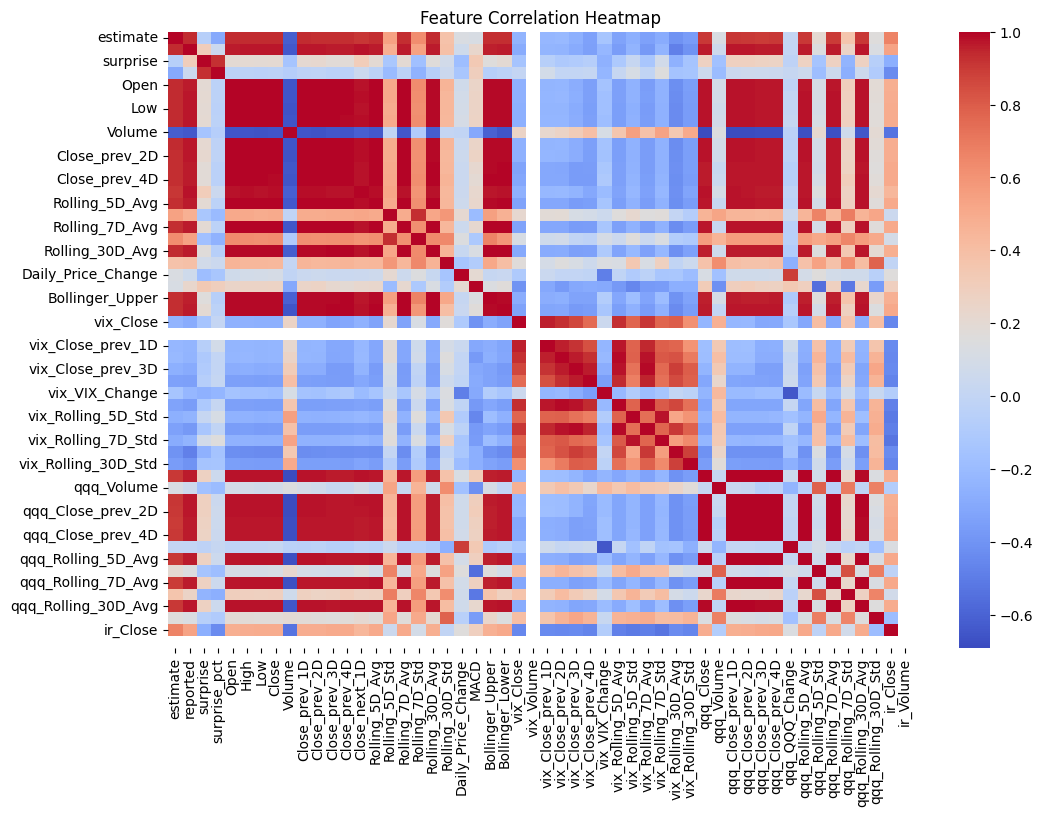

In [20]:
# 2. Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = merged_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

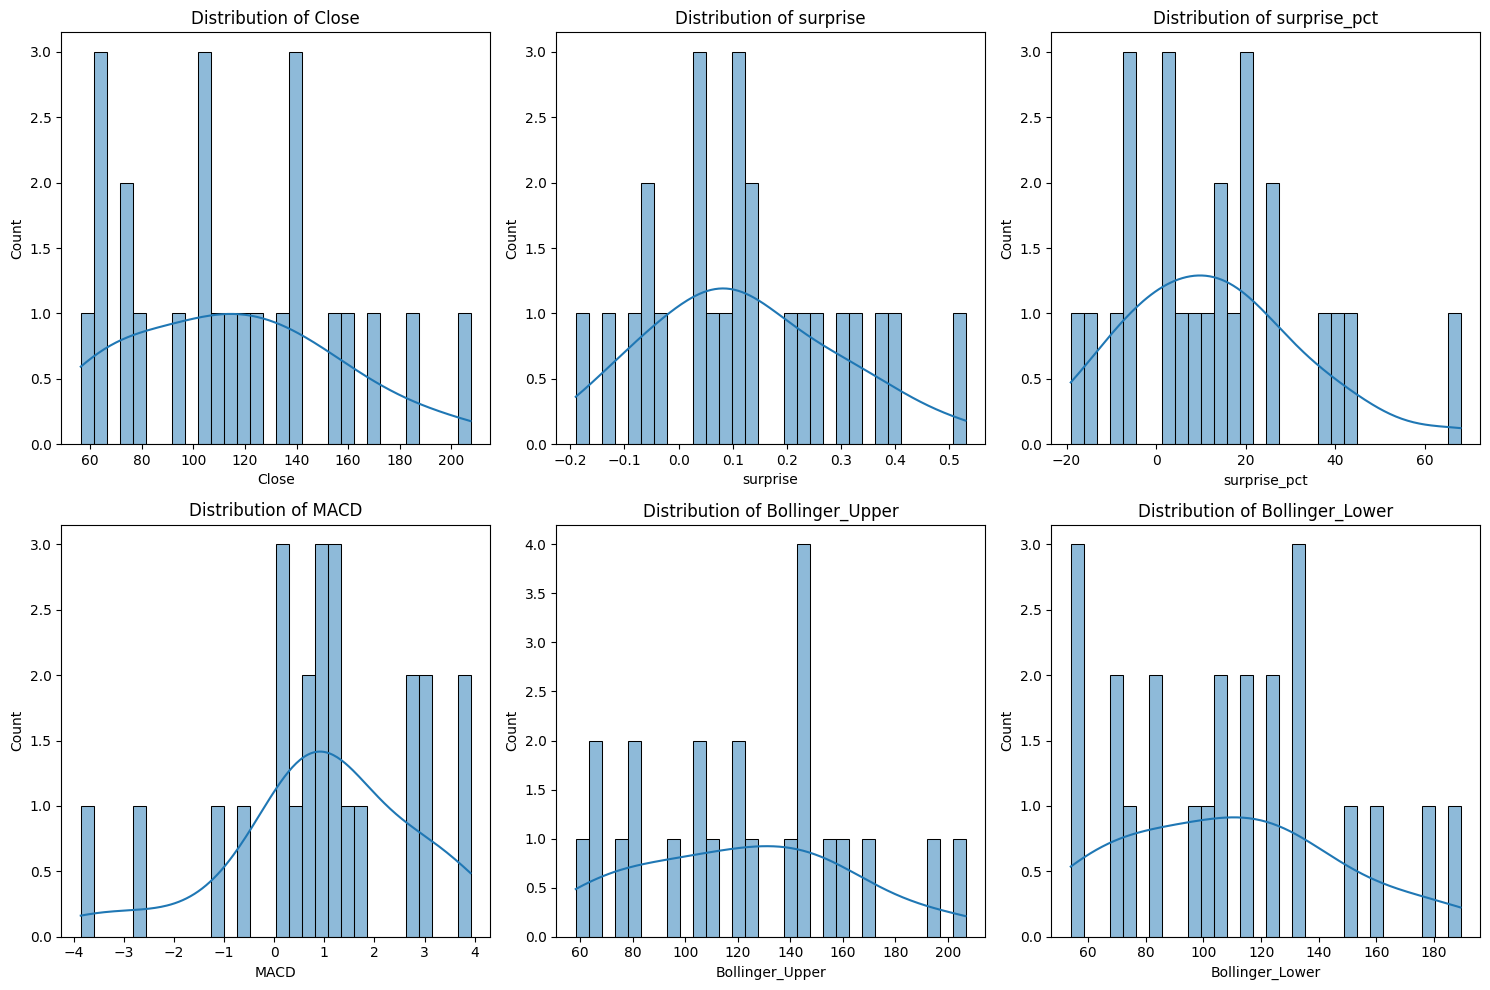

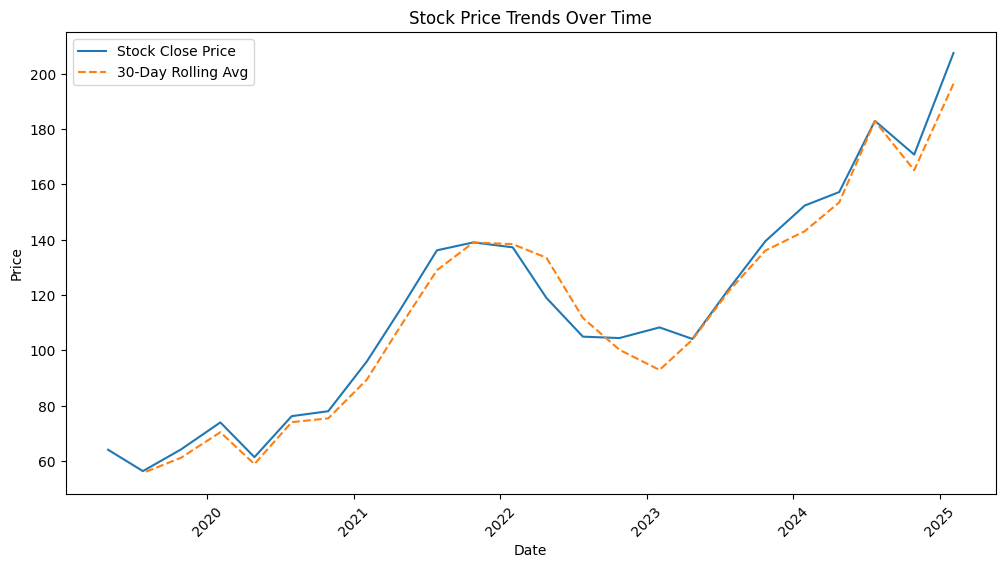

In [21]:
numeric_features = ['Close', 'surprise', 'surprise_pct', 'MACD', 'Bollinger_Upper', 'Bollinger_Lower']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(merged_df[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()

# 4. Time Series Trends
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['Close'], label='Stock Close Price')
plt.plot(merged_df['date'], merged_df['Rolling_30D_Avg'], label='30-Day Rolling Avg', linestyle='dashed')
plt.legend()
plt.title("Stock Price Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

Missing Data Count:
 Close_prev_3D          1
Close_prev_4D          1
Rolling_5D_Avg         1
Rolling_5D_Std         1
Rolling_7D_Avg         1
Rolling_7D_Std         1
Rolling_30D_Avg        1
Rolling_30D_Std        1
Bollinger_Upper        1
Bollinger_Lower        1
vix_Close_prev_4D      1
vix_Rolling_5D_Avg     1
vix_Rolling_5D_Std     1
vix_Rolling_7D_Avg     1
vix_Rolling_7D_Std     1
vix_Rolling_30D_Avg    1
vix_Rolling_30D_Std    1
qqq_Close_prev_3D      1
qqq_Close_prev_4D      1
qqq_Rolling_5D_Avg     1
qqq_Rolling_5D_Std     1
qqq_Rolling_7D_Avg     1
qqq_Rolling_7D_Std     1
qqq_Rolling_30D_Avg    1
qqq_Rolling_30D_Std    1
dtype: int64


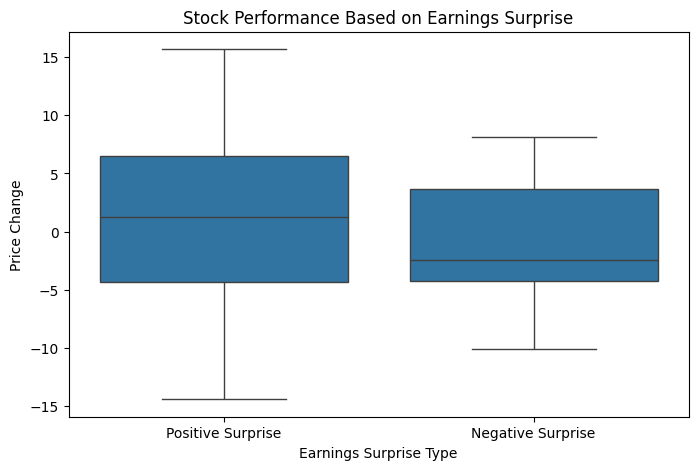

In [22]:
missing_data = merged_df.isnull().sum()
print("Missing Data Count:\n", missing_data[missing_data > 0])

# 6. Stock Performance Around Earnings Dates
merged_df['price_change'] = merged_df['Close_next_1D'] - merged_df['Close']
plt.figure(figsize=(8, 5))
sns.boxplot(x=np.where(merged_df['surprise'] > 0, "Positive Surprise", "Negative Surprise"),
            y=merged_df['price_change'])
plt.title("Stock Performance Based on Earnings Surprise")
plt.xlabel("Earnings Surprise Type")
plt.ylabel("Price Change")
plt.show()


# Simple Regression and Causal Graph

This is built on just Google earnings data for the past 6 years, there is a lot of correlation with companies in similar sectors, with similar growth trajectory, past reaction to earnings, etc. Hence, by aggregating these different companies' earnings data together, we can create a more reflective model. However, though using just 24 rows of Google dataset produce insignificant results, it is still implemented here to show what the pipeline would look like.

In [23]:
y = merged_df['Close_next_1D']
X = merged_df.drop(columns=['Close_next_1D', 'date', 'time'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

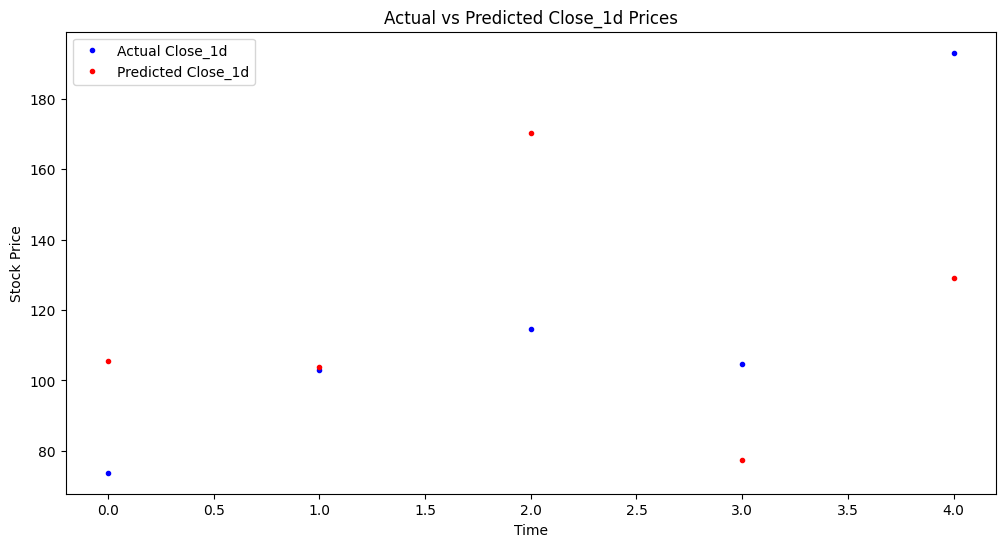

Mean Squared Error: 150.5933
R-Squared: 0.9059


In [24]:
if 'date' in merged_df.columns:
    X_test['date'] = merged_df.loc[X_test.index, 'date']
    X_test = X_test.sort_values('date')
    y_test = y_test.loc[X_test.index]
    y_pred = y_pred[np.argsort(X_test['date'])]

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, '.', label="Actual Close_1d", color='blue')
plt.plot(y_pred, '.', label="Predicted Close_1d", color='red')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Close_1d Prices")
plt.legend()
plt.show()

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-Squared: {r2:.4f}")

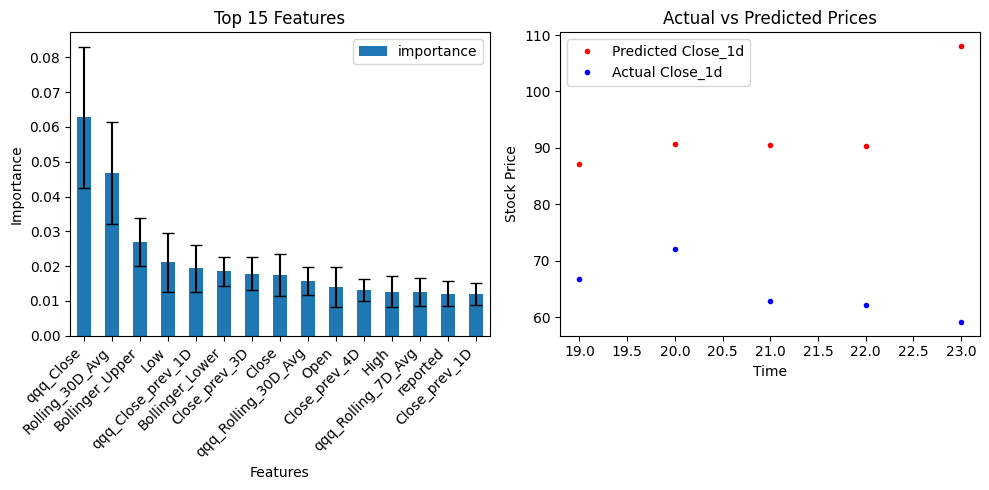

In [25]:
def advanced_stock_prediction_analysis(merged_df):
    exclude_cols = ['date', 'time', 'Close_next_1D']
    numeric_cols = [col for col in merged_df.columns if col not in exclude_cols]
    X = merged_df[numeric_cols]
    y = merged_df['Close_next_1D']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    tscv = TimeSeriesSplit(n_splits=5)

    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

    cv_scores = cross_val_score(
        rf_model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_squared_error'
    )

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    perm_importance = permutation_importance(
        rf_model,
        X_train,
        y_train,
        n_repeats=10,
        random_state=42
    )

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    feature_importance.head(15).plot(x='feature', y='importance', kind='bar',
                                     yerr='std', ax=plt.gca(), capsize=4)
    plt.title('Top 15 Features')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(y_test.index, y_pred, '.', label="Predicted Close_1d", color='red')
    plt.plot(y_test.index, y_test, '.', label="Actual Close_1d", color='blue')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        'model': rf_model,
        'cv_scores': cv_scores,
        'feature_importance': feature_importance,
        'predictions': y_pred,
        'metrics': {
            'MSE': mse,
            'MAE': mae,
            'R2': r2
        }
    }

results = advanced_stock_prediction_analysis(merged_df)

In [26]:
print("Model Performance Metrics:")
for metric, value in results['metrics'].items():
    print(f"{metric}: {value:.4f}")

print("\nTop 10 Most Important Features:")
print(results['feature_importance'].head(10).to_string(index=False))

Model Performance Metrics:
MSE: 941.3356
MAE: 28.7259
R2: -46.9651

Top 10 Most Important Features:
            feature  importance      std
          qqq_Close    0.062760 0.020280
    Rolling_30D_Avg    0.046779 0.014747
    Bollinger_Upper    0.026858 0.006926
                Low    0.021063 0.008448
  qqq_Close_prev_1D    0.019397 0.006769
    Bollinger_Lower    0.018507 0.004178
      Close_prev_3D    0.017867 0.004725
              Close    0.017349 0.006077
qqq_Rolling_30D_Avg    0.015740 0.004048
               Open    0.014001 0.005830


In [49]:
def create_statistical_causal_graph(df, target_col='Close_next_1D', alpha=0.05, max_lag=5):
    df_numeric = df.select_dtypes(include=[np.number]).copy()
    df_numeric = df_numeric.fillna(df_numeric.mean())

    G = nx.DiGraph()

    features = [col for col in df_numeric.columns if col != target_col]
    G.add_nodes_from(features + [target_col])

    granger_edges = []

    for feature in features:
        granger_data = pd.concat([df_numeric[feature], df_numeric[target_col]], axis=1)
        try:
            gc_results = grangercausalitytests(granger_data, maxlag=max_lag, verbose=False)

            for lag in range(1, max_lag + 1):
                p_value = gc_results[lag][0]['ssr_ftest'][1]
                if p_value < alpha:
                    granger_edges.append((feature, target_col))
                    break
        except:
            print(f"  Warning: Granger test failed for {feature}")

    G.add_edges_from(granger_edges)

    correlation_edges = []

    for feature in features:
        try:
            corr, p_value = pearsonr(df_numeric[feature], df_numeric[target_col])

            if abs(corr) > 0.3 and p_value < alpha:
                if any(time_word in feature.lower() for time_word in ['prev', 'lag', 'past', 'rolling', 'avg', 'std']):
                    correlation_edges.append((feature, target_col))
        except:
            print(f"  Warning: Correlation test failed for {feature}")

    G.add_edges_from(correlation_edges)

    try:
        if len(features) > 15:
            correlations = []
            for feature in features:
                try:
                    corr, _ = pearsonr(df_numeric[feature], df_numeric[target_col])
                    correlations.append((feature, abs(corr)))
                except:
                    correlations.append((feature, 0))

            selected_features = [f[0] for f in sorted(correlations, key=lambda x: x[1], reverse=True)[:15]]
        else:
            selected_features = features

        subset_df = df_numeric[selected_features + [target_col]]

        scaler = StandardScaler()
        subset_scaled = pd.DataFrame(scaler.fit_transform(subset_df), columns=subset_df.columns)

        try:
            pc = PC(data=subset_scaled)
            pc_skeleton = pc.estimate(variant="stable", ci_test=pgmpy_pearsonr, return_type="skeleton", significance_level=alpha)

            pc_edges = []
            for edge in pc_skeleton.edges():
                if target_col in edge:
                    if edge[0] == target_col:
                        pc_edges.append((edge[1], edge[0]))
                    else:
                        pc_edges.append(edge)

            G.add_edges_from(pc_edges)
        except Exception as e:
            print(f"  PC algorithm failed: {e}")

            try:
                hc = HillClimbSearch(subset_scaled)
                hc_model = hc.estimate()

                hc_edges = []
                for edge in hc_model.edges():
                    if target_col in edge:
                        if edge[0] == target_col:
                            hc_edges.append((edge[1], edge[0]))
                        else:
                            hc_edges.append(edge)

                G.add_edges_from(hc_edges)
            except Exception as e:
                print(f"  Hill Climbing algorithm failed: {e}")
    except Exception as e:
        print(f"  Constraint-based discovery failed: {e}")


    direct_causes = list(G.predecessors(target_col))
    print(f"  Direct causes of {target_col}: {direct_causes}")

    indirect_causes = []
    for feature in features:
        if feature not in direct_causes and nx.has_path(G, feature, target_col):
            indirect_causes.append(feature)
    print(f"  Indirect causes of {target_col}: {indirect_causes}")

    try:
        centrality = nx.betweenness_centrality(G)
        sorted_centrality = sorted([(node, score) for node, score in centrality.items()
                                   if node != target_col],
                                  key=lambda x: x[1], reverse=True)
        central_nodes = [node[0] for node in sorted_centrality[:min(5, len(sorted_centrality))]]
    except:
        central_nodes = []
        print("  Warning: Centrality calculation failed")

    important_features = list(set(direct_causes + indirect_causes + central_nodes))

    if len(important_features) < 5 and len(features) > 10:
        X = df_numeric[features]
        y = df_numeric[target_col]

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        lasso = LassoCV(cv=5, random_state=42)
        lasso.fit(X_scaled, y)

        lasso_features = [features[i] for i in range(len(features)) if abs(lasso.coef_[i]) > 0]

        important_features = list(set(important_features + lasso_features))

    print(f"Final list of important features: {important_features}")

    return G, important_features

def visualize_causal_graph(G, important_features, title="Statistical Causal Graph"):
    plt.figure(figsize=(12, 10))

    pos = nx.spring_layout(G, k=0.5, seed=42)

    regular_nodes = [node for node in G.nodes() if node not in important_features]
    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes,
                         node_color='lightblue', node_size=1000, alpha=0.7)

    nx.draw_networkx_nodes(G, pos, nodelist=important_features,
                         node_color='red', node_size=1500, alpha=0.9)

    target_nodes = [node for node in G.nodes() if 'next' in node.lower()]
    nx.draw_networkx_nodes(G, pos, nodelist=target_nodes,
                         node_color='green', node_size=2000, alpha=0.9)

    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15,
                         edge_color='gray', width=1.5, alpha=0.7)

    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


<ipython-input-49-1f012d2e085b>:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(df_numeric[feature], df_numeric[target_col])
<ipython-input-49-1f012d2e085b>:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(df_numeric[feature], df_numeric[target_col])


  0%|          | 0/5 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/pgmpy/estimators/CITests.py:503: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  coef, p_value = stats.pearsonr(residual_X, residual_Y)
/usr/local/lib/python3.11/dist-packages/pgmpy/estimators/CITests.py:503: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  coef, p_value = stats.pearsonr(residual_X, residual_Y)
/usr/local/lib/python3.11/dist-packages/pgmpy/estimators/CITests.py:503: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  coef, p_value = stats.pearsonr(residual_X, residual_Y)
/usr/local/lib/python3.11/dist-packages/pgmpy/estimators/CITests.py:503: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  coef, p_value = stats.pearsonr(residual_X, residual_Y)
/usr/local/lib/python3.11/dist-packages/pgmpy/estimat

  PC algorithm failed: 'tuple' object has no attribute 'edges'


/usr/local/lib/python3.11/dist-packages/pgmpy/estimators/CITests.py:503: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  coef, p_value = stats.pearsonr(residual_X, residual_Y)
/usr/local/lib/python3.11/dist-packages/pgmpy/estimators/CITests.py:503: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  coef, p_value = stats.pearsonr(residual_X, residual_Y)
/usr/local/lib/python3.11/dist-packages/pgmpy/estimators/CITests.py:503: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  coef, p_value = stats.pearsonr(residual_X, residual_Y)
/usr/local/lib/python3.11/dist-packages/pgmpy/estimators/CITests.py:503: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  coef, p_value = stats.pearsonr(residual_X, residual_Y)
/usr/local/lib/python3.11/dist-packages/pgmpy/estimators/CITests.py:503: ConstantInputWarning: An input 

  0%|          | 0/1000000 [00:00<?, ?it/s]

  Direct causes of Close_next_1D: ['Volume', 'Daily_Price_Change', 'vix_VIX_Change', 'qqq_Close', 'qqq_Close_prev_1D', 'qqq_Close_prev_2D', 'qqq_Close_prev_3D', 'qqq_Close_prev_4D', 'qqq_QQQ_Change', 'qqq_Rolling_5D_Avg', 'qqq_Rolling_7D_Avg', 'Close_prev_1D', 'Close_prev_2D', 'Close_prev_3D', 'Close_prev_4D', 'Rolling_5D_Avg', 'Rolling_5D_Std', 'Rolling_7D_Avg', 'Rolling_7D_Std', 'Rolling_30D_Avg', 'Rolling_30D_Std', 'qqq_Rolling_30D_Avg']
  Indirect causes of Close_next_1D: []
Final list of important features: ['qqq_Close_prev_3D', 'Close_prev_2D', 'reported', 'Open', 'qqq_Close_prev_4D', 'Rolling_5D_Std', 'qqq_Rolling_30D_Avg', 'Rolling_7D_Avg', 'Close_prev_1D', 'qqq_Close_prev_2D', 'qqq_Close', 'qqq_Close_prev_1D', 'qqq_QQQ_Change', 'Rolling_5D_Avg', 'Daily_Price_Change', 'Volume', 'surprise_pct', 'Close_prev_4D', 'Rolling_30D_Std', 'Close_prev_3D', 'vix_VIX_Change', 'qqq_Rolling_5D_Avg', 'Rolling_30D_Avg', 'estimate', 'Rolling_7D_Std', 'surprise', 'qqq_Rolling_7D_Avg']


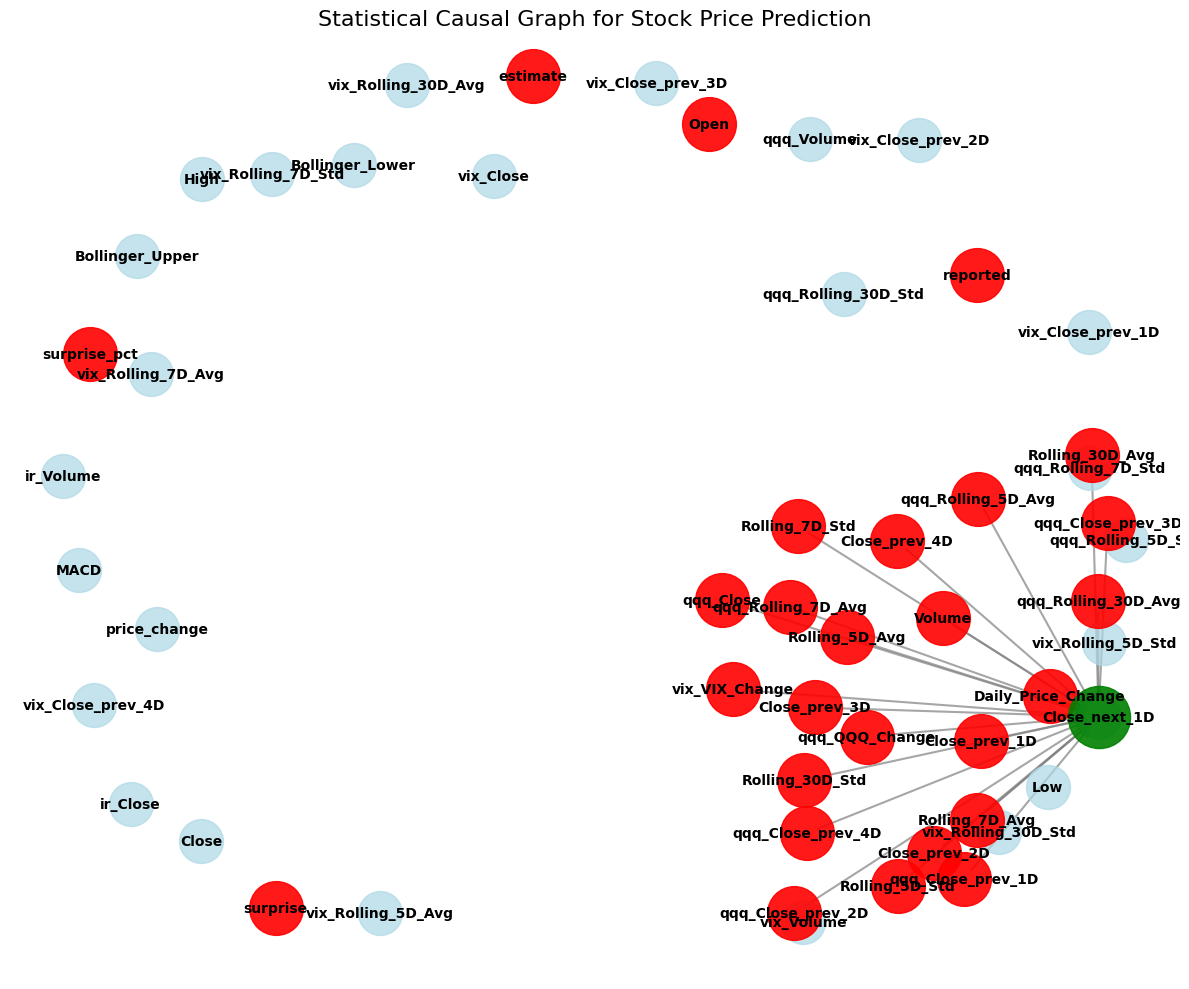


Identified 27 important features for predicting Close_next_1D:
1. qqq_Close_prev_3D
2. Close_prev_2D
3. reported
4. Open
5. qqq_Close_prev_4D
6. Rolling_5D_Std
7. qqq_Rolling_30D_Avg
8. Rolling_7D_Avg
9. Close_prev_1D
10. qqq_Close_prev_2D
11. qqq_Close
12. qqq_Close_prev_1D
13. qqq_QQQ_Change
14. Rolling_5D_Avg
15. Daily_Price_Change
16. Volume
17. surprise_pct
18. Close_prev_4D
19. Rolling_30D_Std
20. Close_prev_3D
21. vix_VIX_Change
22. qqq_Rolling_5D_Avg
23. Rolling_30D_Avg
24. estimate
25. Rolling_7D_Std
26. surprise
27. qqq_Rolling_7D_Avg


In [50]:
def extract_important_features(df, target_col='Close_next_1D', max_lag=3):
    G, important_features = create_statistical_causal_graph(df, target_col, max_lag=max_lag)

    visualize_causal_graph(G, important_features,
                        title="Statistical Causal Graph for Stock Price Prediction")

    print(f"\nIdentified {len(important_features)} important features for predicting {target_col}:")
    for i, feature in enumerate(important_features, 1):
        print(f"{i}. {feature}")

    return important_features, G

important_features, causal_graph = extract_important_features(merged_df)